<a href="https://colab.research.google.com/github/AmithCarmel/CPG-and-RNN-Control-Framework-for-Adaptive-Robotic-Locomotion-/blob/main/Copy_of_CPG_RNN_DEC_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Simulating network with N=3 neurons ...
Integration complete. Status: The solver successfully reached the end of the integration interval.

Simulating network with N=4 neurons ...
Integration complete. Status: The solver successfully reached the end of the integration interval.

Simulating network with N=5 neurons ...
Integration complete. Status: The solver successfully reached the end of the integration interval.

Simulating network with N=6 neurons ...
Integration complete. Status: The solver successfully reached the end of the integration interval.


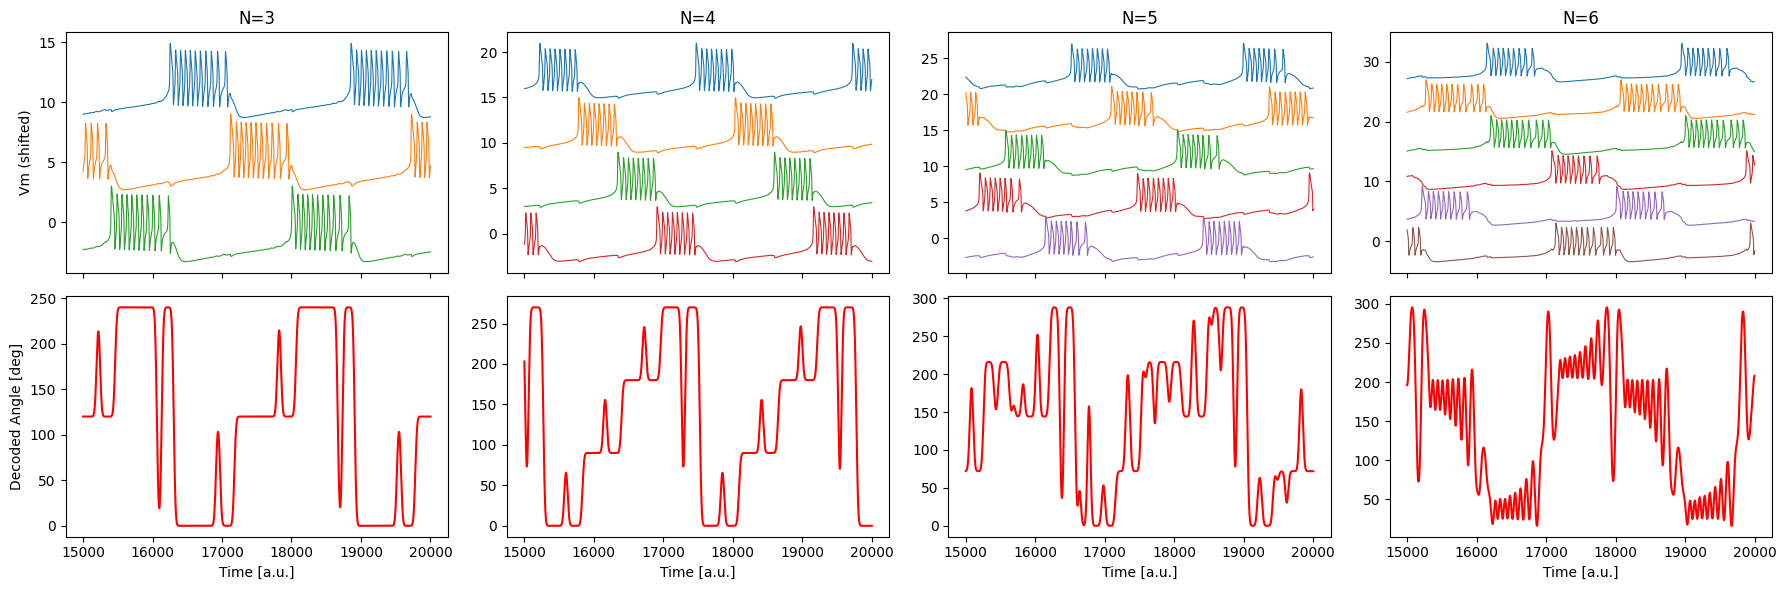


✅ Phase data (raw + smooth) saved to cpg_phase_data.csv


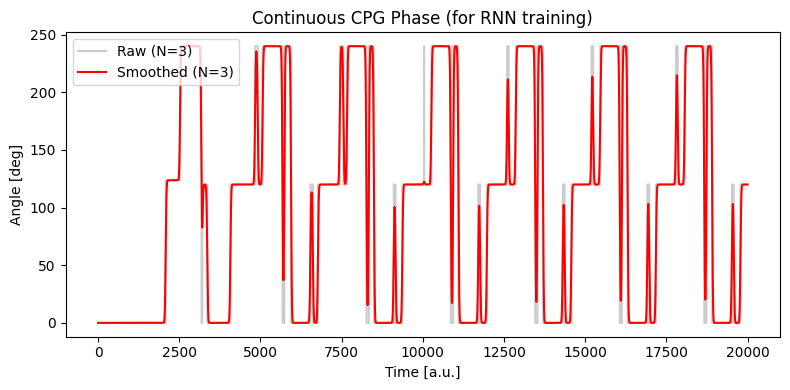

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.ndimage import gaussian_filter1d
import pandas as pd

Tf, Ts, Tus = 1.0, 50.0, 2500.0
alpha = [-2.0, 2.0, -1.5, 1.5]
delta = [0.0, 0.0, -1.5, -1.5]
Iapp = -1.6
g_inh = -0.3
b, dsyn = 5.0, -1.0
tmax = 20000
ti = 15000
spike_thresh = -2.0
servo_scale = 30.0

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-b*(x-dsyn)))


def neuron_eqs(S, I):
    vm, vf, vs, vus = S
    dvm = -vm - alpha[0]*np.tanh(vf-delta[0]) \
              - alpha[1]*np.tanh(vs-delta[1]) \
              - alpha[2]*np.tanh(vs-delta[2]) \
              - alpha[3]*np.tanh(vus-delta[3]) + I
    dvf = (vm - vf)/Tf
    dvs = (vm - vs)/Ts
    dvus = (vm - vus)/Tus
    return [dvm, dvf, dvs, dvus]


def make_network(N):
    asyn = g_inh * np.ones((N, N))
    np.fill_diagonal(asyn, 0.0)

    def network(t, S):
        dS = []
        Vs = np.array([S[i*4+2] for i in range(N)])
        Isyn = asyn @ sigmoid(Vs)
        for i in range(N):
            Si = S[i*4:(i+1)*4]
            dS.extend(neuron_eqs(Si, Iapp + Isyn[i]))
        return dS

    return network

decoded_data = []
fig, axes = plt.subplots(2, 4, figsize=(18, 6), sharex='col')

for idx, N in enumerate([3, 4, 5, 6]):
    print(f"\nSimulating network with N={N} neurons ...")


    S0 = np.zeros(N*4)
    for i in range(N):
        S0[i*4] = -1 + 0.1*np.random.randn()

    t_eval = np.arange(0, tmax+1, 1)
    sol = solve_ivp(make_network(N), (0.0, float(tmax)), S0,
                    method="BDF", t_eval=t_eval, atol=1e-6, rtol=1e-4)

    print("Integration complete. Status:", sol.message)



    for i in range(N):
        Vm = sol.y[i*4, :]
        axes[0, idx].plot(sol.t[ti:], Vm[ti:] + 6*(N-i-1), lw=0.8)
    axes[0, idx].set_title(f"N={N}")
    if idx == 0:
        axes[0, idx].set_ylabel("Vm (shifted)")


    phases = np.linspace(0.0, 2.0*np.pi, N, endpoint=False)
    decoded = []
    prev_vm = sol.y[0::4, 0].copy()
    theta_last = 0.0

    for k, t in enumerate(sol.t):
        spk = []
        for i in range(N):
            vm = sol.y[i*4, k]
            if vm > spike_thresh and prev_vm[i] <= spike_thresh:
                spk.append(1)
            else:
                spk.append(0)
            prev_vm[i] = vm

        spk = np.array(spk)
        if np.sum(spk) > 0:
            x = np.sum(spk * np.cos(phases))
            y = np.sum(spk * np.sin(phases))
            theta = np.degrees(np.arctan2(y, x)) % 360.0
            theta_last = theta
        else:
            theta = theta_last

        decoded.append(theta)

    decoded = np.array(decoded)

    decoded_smooth = gaussian_filter1d(decoded, sigma=20)


    axes[1, idx].plot(sol.t[ti:], decoded_smooth[ti:], 'r')
    if idx == 0:
        axes[1, idx].set_ylabel("Decoded Angle [deg]")
    axes[1, idx].set_xlabel("Time [a.u.]")

    decoded_data.append(
        pd.DataFrame({
            "time": sol.t,
            f"theta_raw_N{N}": decoded,
            f"theta_smooth_N{N}": decoded_smooth
        })
    )

plt.tight_layout()
plt.show()

merged = decoded_data[0]
for df in decoded_data[1:]:
    merged = pd.merge(merged, df, on="time", how="outer")

merged.to_csv("cpg_phase_data.csv", index=False)
print("\n Phase data (raw + smooth) saved to cpg_phase_data.csv")


plt.figure(figsize=(8, 4))
plt.plot(merged["time"], merged["theta_raw_N3"], 'gray', alpha=0.4, label="Raw (N=3)")
plt.plot(merged["time"], merged["theta_smooth_N3"], 'r', label="Smoothed (N=3)")
plt.title("Continuous CPG Phase (for RNN training)")
plt.xlabel("Time [a.u.]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.tight_layout()
plt.show()


Train samples: 15976, Test samples: 3994
Epoch  10/50 | Train loss: 0.407930 | Val loss: 0.408122
Epoch  20/50 | Train loss: 0.268212 | Val loss: 0.267962
Epoch  30/50 | Train loss: 0.110805 | Val loss: 0.112137
Epoch  40/50 | Train loss: 0.030313 | Val loss: 0.023263
Epoch  50/50 | Train loss: 0.017402 | Val loss: 0.017645


/tmp/ipython-input-3859579388.py:94: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_angles = np.arctan2(y_test[:,0], y_test[:,1])
/tmp/ipython-input-3859579388.py:97: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_deg = np.rad2deg(true_angles) % 360


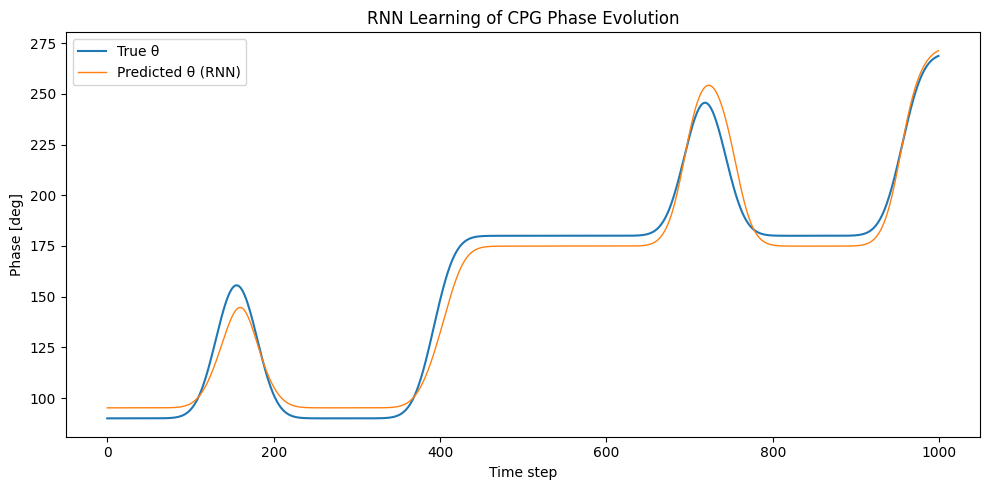

✅ Model saved to phase_rnn_model.pt


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

data = pd.read_csv("cpg_phase_data.csv")

col = "theta_smooth_N4" # we can choose the network
phase_deg = data[col].dropna().to_numpy()

# Normalizing time series
phase_rad = np.deg2rad(phase_deg)
sin_phase = np.sin(phase_rad)
cos_phase = np.cos(phase_rad)

# dataset as sinθ and  cosθ
X = np.stack([sin_phase, cos_phase], axis=1)

seq_len = 30
pred_horizon = 1  # next_step prediction

def make_sequences(X, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len - pred_horizon):
        xs.append(X[i:i+seq_len])
        ys.append(X[i+seq_len])
    return np.array(xs), np.array(ys)

X_seq, y_seq = make_sequences(X, seq_len)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f"Train samples: {len(X_train)}, Test samples: {len(X_test)}")

class PhaseRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # output sinθ, cosθ

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = PhaseRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

# Training
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    pred = model(X_train)
    loss = criterion(pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 10 == 0:
        model.eval()
        val_loss = criterion(model(X_test), y_test).item()
        print(f"Epoch {epoch+1:3d}/{epochs} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")


model.eval()
with torch.no_grad():
    pred_test = model(X_test).numpy()

true_angles = np.arctan2(y_test[:,0], y_test[:,1])
pred_angles = np.arctan2(pred_test[:,0], pred_test[:,1])

true_deg = np.rad2deg(true_angles) % 360
pred_deg = np.rad2deg(pred_angles) % 360

plt.figure(figsize=(10,5))
plt.plot(true_deg[:1000], label="True θ", lw=1.5)
plt.plot(pred_deg[:1000], label="Predicted θ (RNN)", lw=1)
plt.xlabel("Time step")
plt.ylabel("Phase [deg]")
plt.title("RNN Learning of CPG Phase Evolution")
plt.legend()
plt.tight_layout()
plt.show()


torch.save(model.state_dict(), "phase_rnn_model.pt")
print("Model saved to phase_rnn_model.pt")


✅ Dataset ready: 15976 train, 3994 test samples
Epoch  10/100 | Train loss: 0.370056 | Val loss: 0.369585
Epoch  20/100 | Train loss: 0.238730 | Val loss: 0.237230
Epoch  30/100 | Train loss: 0.077077 | Val loss: 0.075881
Epoch  40/100 | Train loss: 0.012764 | Val loss: 0.015842
Epoch  50/100 | Train loss: 0.007830 | Val loss: 0.008149
Epoch  60/100 | Train loss: 0.005461 | Val loss: 0.006639
Epoch  70/100 | Train loss: 0.002928 | Val loss: 0.003547
Epoch  80/100 | Train loss: 0.002911 | Val loss: 0.003439
Epoch  90/100 | Train loss: 0.002542 | Val loss: 0.003093
Epoch 100/100 | Train loss: 0.002292 | Val loss: 0.002812

=== Evaluation Metrics ===
RMSE: 4.2785 degrees
Correlation: 0.9989

=== Sample Predicted vs Actual Phase Angles (deg) ===
Step    0 | True:   90.00° | Pred:   89.98°
Step    1 | True:   90.00° | Pred:   89.98°
Step    2 | True:   90.00° | Pred:   89.98°
Step    3 | True:   90.00° | Pred:   89.98°
Step    4 | True:   90.00° | Pred:   89.98°
Step    5 | True:   90.00° |

/tmp/ipython-input-3691225934.py:98: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_angles = np.arctan2(y_test[:, 0], y_test[:, 1])
/tmp/ipython-input-3691225934.py:101: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  true_deg = np.rad2deg(true_angles) % 360


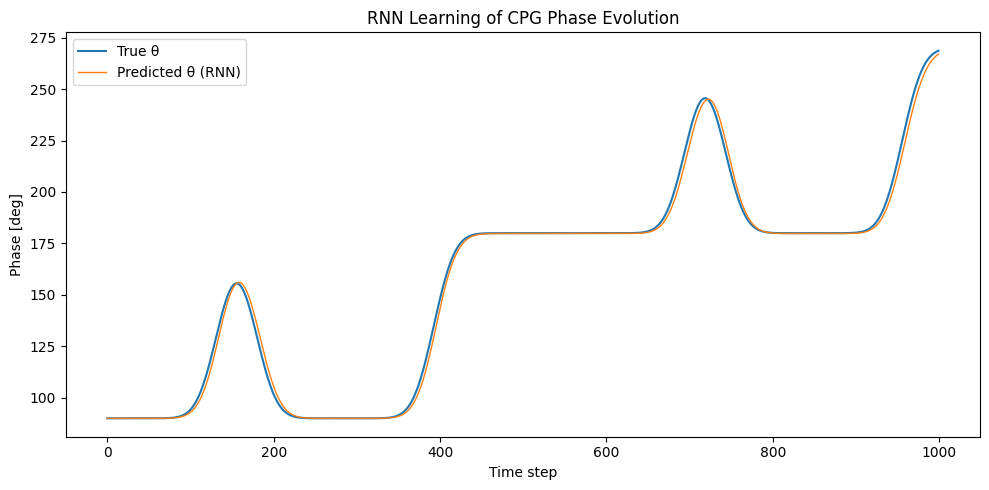


✅ Model saved to phase_rnn_model.pt


In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

data = pd.read_csv("cpg_phase_data.csv")

col = "theta_smooth_N4"
phase_deg = data[col].dropna().to_numpy()

phase_rad = np.deg2rad(phase_deg)
sin_phase = np.sin(phase_rad)
cos_phase = np.cos(phase_rad)

X_all = np.stack([sin_phase, cos_phase], axis=1)


seq_len = 30
pred_horizon = 1

def make_sequences(X, seq_len):
    xs, ys = [], []
    for i in range(len(X) - seq_len - pred_horizon):
        xs.append(X[i:i+seq_len])
        ys.append(X[i+seq_len])
    return np.array(xs), np.array(ys)

X_seq, y_seq = make_sequences(X_all, seq_len)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

print(f" Dataset ready: {len(X_train)} train, {len(X_test)} test samples")

class PhaseRNN(nn.Module):
    def __init__(self, input_size=2, hidden_size=64, num_layers=1):
        super().__init__()
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 2)  # output sinθ, cosθ

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])
        return out

model = PhaseRNN()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()


epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(X_test), y_test).item()
        print(f"Epoch {epoch+1:3d}/{epochs} | Train loss: {loss.item():.6f} | Val loss: {val_loss:.6f}")


model.eval()
with torch.no_grad():
    pred_test = model(X_test).numpy()

true_angles = np.arctan2(y_test[:, 0], y_test[:, 1])
pred_angles = np.arctan2(pred_test[:, 0], pred_test[:, 1])

true_deg = np.rad2deg(true_angles) % 360
pred_deg = np.rad2deg(pred_angles) % 360


rmse = np.sqrt(mean_squared_error(true_deg, pred_deg))


corr = np.corrcoef(true_deg, pred_deg)[0, 1]

print("\n=== Evaluation Metrics ===")
print(f"RMSE: {rmse:.4f} degrees")
print(f"Correlation: {corr:.4f}")


print("\n=== Sample Predicted vs Actual Phase Angles (deg) ===")
for i in range(10):
    print(f"Step {i:4d} | True: {true_deg[i]:7.2f}° | Pred: {pred_deg[i]:7.2f}°")

plt.figure(figsize=(10,5))
plt.plot(true_deg[:1000], label="True θ", lw=1.5)
plt.plot(pred_deg[:1000], label="Predicted θ (RNN)", lw=1)
plt.xlabel("Time step")
plt.ylabel("Phase [deg]")
plt.title("RNN Learning of CPG Phase Evolution")
plt.legend()
plt.tight_layout()
plt.show()


torch.save(model.state_dict(), "phase_rnn_model.pt")
print("\n Model saved to phase_rnn_model.pt")
